# Q1
# Variational Inference (VI)

**Variational Inference** approximates $p(\theta \mid X)$ by choosing a simpler, “variational” family $\bigl\{q_{\lambda}(\theta)\bigr\}$ and then optimizing the parameters $\lambda$ so that $q_{\lambda}(\theta)$ is as close as possible to $p(\theta \mid X)$. A common measure of “closeness” is the KL-divergence.

---

## The Posterior Problem

We want the Bayesian posterior distribution:

$$
p(\theta \mid X) \;=\; \frac{p(X,\theta)}{p(X)},
\quad
\text{where}
\quad
p(X) \;=\; \int p(X,\theta)\,d\theta.
$$

Because $\displaystyle \int p(X,\theta)\,d\theta$ is often **intractable**, we need an alternative to direct computation.

---

## The Evidence Lower Bound (ELBO)

Using Jensen’s inequality, we derive the **Evidence Lower Bound**:

$$
\log p(X)
\;=\;
\log \int p(X,\theta)\,d\theta
\;=\;
\log \,\mathbb{E}_{q(\theta)}\!\Bigl[\tfrac{p(X,\theta)}{q(\theta)}\Bigr]
\;\ge\;
\mathbb{E}_{q(\theta)}\!\bigl[\log p(X,\theta)\;-\;\log q(\theta)\bigr]
\;=\;
\mathrm{ELBO}(q).
$$

Hence:

$$
\mathrm{ELBO}(q)
\;=\;
\mathbb{E}_{q(\theta)}\bigl[\log p(X,\theta)\bigr]
\;-\;
\mathbb{E}_{q(\theta)}\bigl[\log q(\theta)\bigr].
$$

Maximizing $\mathrm{ELBO}(q)$ brings $q(\theta)$ closer to $p(\theta \mid X)$. The tighter the ELBO, the closer our approximation is to the true posterior, and the better our estimate of $\log p(X)$.

---

### Summary of VI/ELBO

1. We have an intractable posterior $p(\theta \mid X)$.
2. Propose a tractable distribution $q(\theta)$.
3. Optimize $q(\theta)$ to **maximize** the ELBO, or equivalently **minimize** $\mathrm{KL}\bigl(q(\theta)\,\|\;p(\theta \mid X)\bigr)$.
4. Use $q(\theta)$ as the approximate posterior for inference/prediction.

---

### Advantages

- Often **faster** than MCMC for large datasets (supports stochastic/mini-batch gradient methods).
- **Scales** well to high dimensions and big data.

### Drawbacks

- The chosen family $q(\theta)$ may be too simple, potentially **underestimating** posterior uncertainty or ignoring multi-modality.
- The **direction** of KL-divergence (from $q$ to $p$) can encourage the approximation to focus on a single mode, missing others.




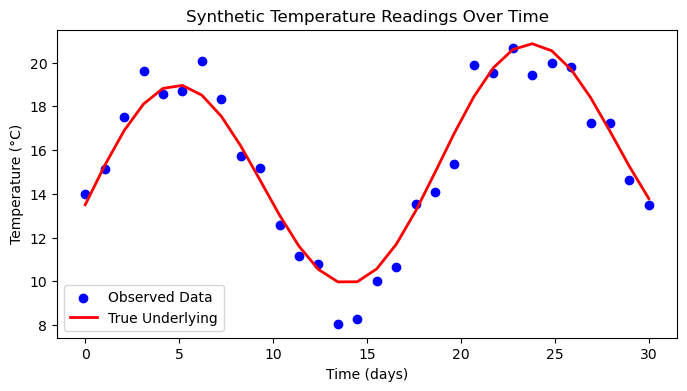

/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [length_scale, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 70 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
length_scale  2.987  0.760   1.667    4.547      0.024    0.028    1177.0   
sigma         2.241  0.573   1.191    3.311      0.016    0.011    1295.0   

              ess_tail  r_hat  
length_scale     622.0    1.0  
sigma           1374.0    1.0  


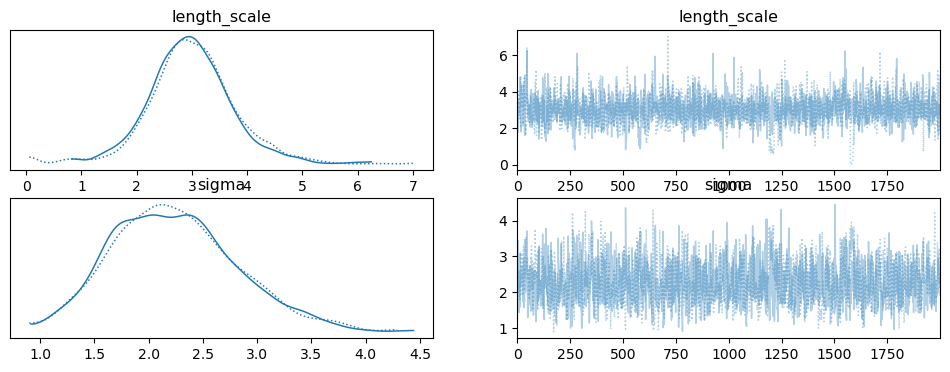

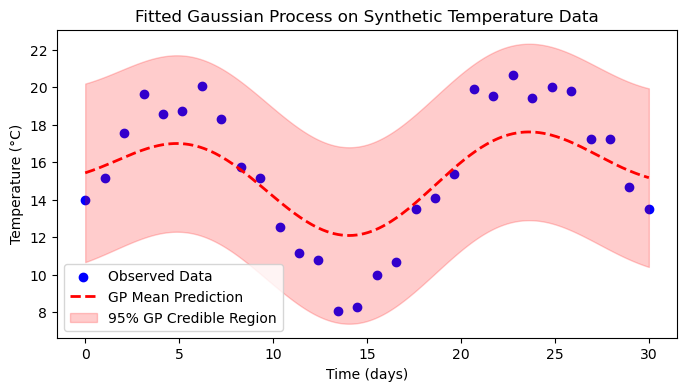

In [2]:
#Q2
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# 1. Generate Synthetic Data
# --------------------------
np.random.seed(42)
time = np.linspace(0, 30, 30)  # 30 days
# True underlying function: sinusoidal + slight trend
true_temp = 15 + 5 * np.sin(time / 3) + 0.1 * (time - 15)
# Observations with noise
observed_temp = true_temp + np.random.normal(0, 1.0, size=len(time))

plt.figure(figsize=(8,4))
plt.scatter(time, observed_temp, c="blue", label="Observed Data")
plt.plot(time, true_temp, c="red", lw=2, label="True Underlying")
plt.xlabel("Time (days)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.title("Synthetic Temperature Readings Over Time")
plt.show()

# 2. Build the Gaussian Process Model in PyMC
# -------------------------------------------
with pm.Model() as gp_model:
    # Convert arrays to shared data in PyMC
    time_shared = pm.MutableData("time", time[:, None])  # shape: (30,1)
    temp_observed = pm.MutableData("temp_obs", observed_temp)

    # Exponential Quadratic (RBF) covariance kernel
    length_scale = pm.Exponential("length_scale", lam=0.5)
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=length_scale)

    # Mean function = constant offset
    mean_func = pm.gp.mean.Constant(c=15)

    # Construct the GP
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)

    # Noise term in the likelihood
    sigma = pm.Exponential("sigma", lam=1.0)

    # GP Marginal Likelihood for observed data
    y_ = gp.marginal_likelihood("y", X=time_shared, y=temp_observed, noise=sigma)

    # Sample the posterior
    trace = pm.sample(
        draws=2000,
        tune=1000,
        cores=2,
        chains=2,
        target_accept=0.9,
        random_seed=42
    )

# 3. Inspect Posterior and Diagnostics
# ------------------------------------
print(az.summary(trace, var_names=["length_scale", "sigma"]))
az.plot_trace(trace, var_names=["length_scale", "sigma"])
plt.show()

# 4. Posterior Predictive: Fitted Curve
# -------------------------------------
with gp_model:
    # Create a dense grid of time points for prediction
    time_dense = np.linspace(0, 30, 300)[:, None]
    
    # Build a dictionary with the *mean* values of the parameters from the trace
    mean_params = {
        "length_scale": float(trace.posterior["length_scale"].mean()),
        "sigma": float(trace.posterior["sigma"].mean())
    }
    
    # Predict the GP mean and variance at the new points
    f_mean, f_var = gp.predict(
        Xnew=time_dense, 
        point=mean_params,   # We provide the needed parameters here
        diag=True, 
        pred_noise=True
    )

# 5. Plot the Results
# -------------------
plt.figure(figsize=(8,4))
plt.scatter(time, observed_temp, c="blue", label="Observed Data")
plt.plot(time_dense, f_mean, "r--", lw=2, label="GP Mean Prediction")
plt.fill_between(
    time_dense.ravel(),
    f_mean - 2*np.sqrt(f_var),
    f_mean + 2*np.sqrt(f_var),
    color="red",
    alpha=0.2,
    label="95% GP Credible Region"
)
plt.xlabel("Time (days)")
plt.ylabel("Temperature (°C)")
plt.title("Fitted Gaussian Process on Synthetic Temperature Data")
plt.legend()
plt.show()

# Discussion:
# -----------
# - 'mean_params' ensures length_scale and sigma are in the dictionary 
#   so gp.predict(...) can replace them correctly.
# - length_scale influences GP "smoothness" over time.
# - sigma models observation noise.
# - The predictions show the posterior mean function and a 95% region 
#   (+/- 2 standard deviations).
# - This approach generalizes to real-world data or extended kernels.

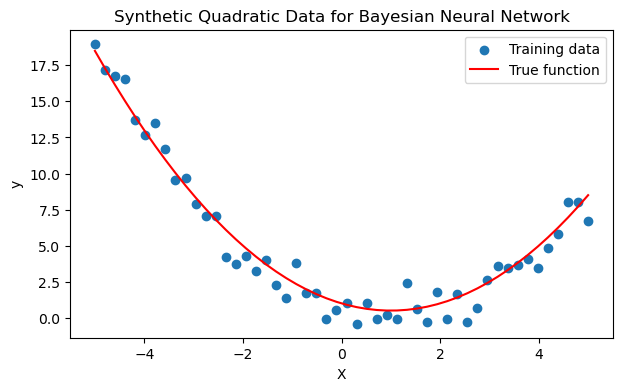

Finished [100%]: Average Loss = 177.62
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
W1[0, 0] -0.147  0.977  -2.007    1.567      0.023    0.016    1864.0   
W1[0, 1]  0.363  0.880  -1.295    1.937      0.020    0.014    2015.0   
W1[0, 2] -0.348  0.881  -1.926    1.337      0.020    0.014    1972.0   
W1[0, 3]  0.273  0.891  -1.504    1.873      0.020    0.016    1946.0   
W1[0, 4] -0.019  0.912  -1.725    1.737      0.021    0.014    1841.0   
W1[0, 5] -0.600  0.768  -1.983    0.889      0.018    0.013    1864.0   
W1[0, 6]  0.405  0.870  -1.263    1.940      0.019    0.014    1996.0   
W1[0, 7]  0.027  0.953  -1.731    1.817      0.021    0.016    2114.0   
W1[0, 8] -0.375  0.867  -1.968    1.192      0.019    0.013    2028.0   
W1[0, 9] -0.216  0.928  -1.866    1.548      0.022    0.014    1768.0   
b1[0]     0.009  1.043  -2.032    1.851      0.022    0.016    2144.0   
b1[1]    -0.013  1.052  -1.919    2.037      0.026    0.017    1627.0   
b1[2]     0.003  1.044  -1.942    1.940      0.024 

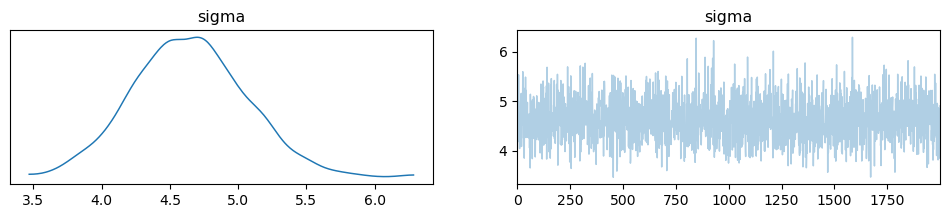

/tmp/ipykernel_52/361451488.py:117: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_pred_hdi = az.hdi(preds, hdi_prob=0.95)


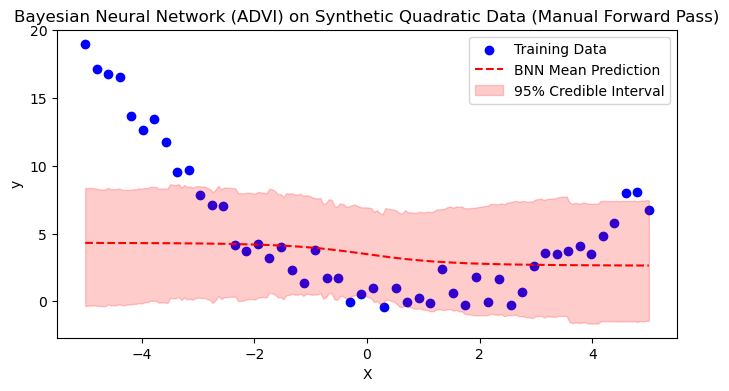

In [7]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Generate Synthetic Data
# ------------------------------------------------
np.random.seed(42)
N = 50  # Number of training points

# X_data: from -5 to +5
X_data = np.linspace(-5, 5, N)

# True function: quadratic + noise
f_true = 0.5 * X_data**2 - X_data + 1.0
noise = np.random.normal(loc=0, scale=1.0, size=N)
y_data = f_true + noise

# Quick plot of the synthetic dataset
plt.figure(figsize=(7, 4))
plt.scatter(X_data, y_data, label="Training data")
plt.plot(X_data, f_true, color="red", label="True function")
plt.title("Synthetic Quadratic Data for Bayesian Neural Network")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

# ------------------------------------------------
# 2. Define a Bayesian Neural Network in PyMC
# ------------------------------------------------
with pm.Model() as bnn_model:
    # Weights and biases:
    #  - W1: shape (1, 10) -> hidden layer with 10 neurons
    #  - b1: shape (10,)
    #  - W2: shape (10, 1) -> output layer
    #  - b2: shape (1,)    -> output bias
    W1 = pm.Normal("W1", mu=0.0, sigma=1.0, shape=(1, 10))
    b1 = pm.Normal("b1", mu=0.0, sigma=1.0, shape=(10,))
    W2 = pm.Normal("W2", mu=0.0, sigma=1.0, shape=(10, 1))
    b2 = pm.Normal("b2", mu=0.0, sigma=1.0, shape=(1,))

    # Use pm.MutableData for training data
    X_in = pm.MutableData("X_in", X_data.reshape(-1, 1))  # shape: (N,1)
    y_obs_data = pm.MutableData("y_obs_data", y_data)     # shape: (N,)

    # Forward pass
    hidden = pm.math.tanh(pm.math.dot(X_in, W1) + b1)   # => shape (N,10)
    out_raw = pm.math.dot(hidden, W2) + b2              # => shape (N,1)
    out = out_raw.flatten()                             # => shape (N,)

    # Likelihood noise
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # Observed node for training data
    y_obs = pm.Normal("y_obs", mu=out, sigma=sigma, observed=y_obs_data)

    # ------------------------------------------------
    # 3. Variational Inference (ADVI)
    # ------------------------------------------------
    # pm.fit sets up the ELBO objective and optimizes
    approx = pm.fit(n=20000, method="advi", progressbar=True)  # Increase steps if needed
    trace = approx.sample(draws=2000, random_seed=42)

# ------------------------------------------------
# 4. Inspect Posterior & Diagnostics
# ------------------------------------------------
print(az.summary(trace, var_names=["W1", "b1", "W2", "b2", "sigma"]))
az.plot_trace(trace, var_names=["sigma"])
plt.show()

# ------------------------------------------------
# 5. Manual Posterior Predictions on New X_test
# ------------------------------------------------

# We will not call pm.sample_posterior_predictive on "out" here.
# Instead, we'll do a manual forward pass over each posterior draw.

# Step 1: Create a new input grid
X_test = np.linspace(-5, 5, 200).reshape(-1, 1)  # shape (200,1)

# Step 2: Extract the posterior draws for each parameter
#    trace.posterior is an xarray with dimensions: (chain, draw, ...)
W1_draws = trace.posterior["W1"].values  # shape (n_chains, n_draws, 1, 10)
b1_draws = trace.posterior["b1"].values  # shape (n_chains, n_draws, 10)
W2_draws = trace.posterior["W2"].values  # shape (n_chains, n_draws, 10, 1)
b2_draws = trace.posterior["b2"].values  # shape (n_chains, n_draws, 1)

# Flatten chain and draw dimensions to combine them => total_samples
n_chains = W1_draws.shape[0]
n_draws = W1_draws.shape[1]
total_samples = n_chains * n_draws

# We'll store all predictions in a 2D array, shape (total_samples, 200)
preds = np.zeros((total_samples, X_test.shape[0]))

# Helper function for the forward pass
def forward_bnn(X, W1_, b1_, W2_, b2_):
    hidden_ = np.tanh(X @ W1_ + b1_)
    out_ = hidden_ @ W2_ + b2_
    return out_.flatten()  # shape (n_test,)

# Step 3: Loop over every sample in the posterior
idx = 0
for c in range(n_chains):
    for d in range(n_draws):
        W1_ = W1_draws[c, d]
        b1_ = b1_draws[c, d]
        W2_ = W2_draws[c, d]
        b2_ = b2_draws[c, d]
        preds[idx] = forward_bnn(X_test, W1_, b1_, W2_, b2_)
        idx += 1

# Step 4: Compute mean and 95% intervals
y_pred_mean = preds.mean(axis=0)
y_pred_hdi = az.hdi(preds, hdi_prob=0.95)

# Plot the results
plt.figure(figsize=(8,4))
plt.scatter(X_data, y_data, color="blue", label="Training Data")
plt.plot(X_test.flatten(), y_pred_mean, "r--", label="BNN Mean Prediction")
plt.fill_between(
    X_test.flatten(),
    y_pred_hdi[:, 0],
    y_pred_hdi[:, 1],
    color="red",
    alpha=0.2,
    label="95% Credible Interval",
)
plt.title("Bayesian Neural Network (ADVI) on Synthetic Quadratic Data (Manual Forward Pass)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()